# SSL Verification and Certificates

**Note:** If any of the other demonstration notebooks are working properly
for you, then there is nothing in this notebook that you need to know about.
You can safely ignore it. The SSL certificates the U.S. Census Bureau uses 
are completely valid and work as intended in almost all cases. But if you
are getting SSL errors, this notebook may be able to help you.

## Background

Some organizations use security proxies or firewalls
that interfere with the proper functioning of these certificates when they are used
from Python code. If you are a part of such an organization, you probably already
know this as you have probably had issues accessing a wide variety of secure
web sites from Python code.

### Solution 1: Don't verify the certificate

One common solution to working in this kind of environments is to ask the Python
`requests` library to either ignore bad SSL certificates. This is done by adding the
`verify=False` argument to APIs like `requests.get()`. So instead of writing something
like

```python
import requests

url = "https://www.mysite.org/document"

response = requests.get(url)
```

you would write

```python
import requests

url = "https://www.mysite.org/document"

response = requests.get(url, verify=False)
```

### Solution 2: Provide your own key

A second solution, which is more secure than just ignoring verification, is to provide your own certificate, like
this

```python
import requests

url = "https://www.mysite.org/document"

# Get this file however your organization's security department
# advises you to and use one of the two syntaxes below as they
# advise you:
cert = "mysite-certificate-file.pem"

# Syntax 1: just the cert file
response = requests.get(url, cert=cert)

# Syntax 2: cert and key in a tuple
response = requests.get(url, cert=(cert, key))
```

### How can we do this in `censusdis`?

The problem is, when you are using `censusdis`, it is managing many different calls to different U.S. Census
APIs on your behalf to download and combine the data and maps you request. You could go patch them all but that
would be a pain. 

In order to avoid this pain, we will rely on a special object that can be found at `censusdis.data.certificates`.
The rest of this notebook demonstrates how it can be used.

Note that as your work through debugging this, you will probably want to move or remove the directory `~/.censusdis/data/shapefiles`
regularly. This directory is a cache of map files. If you want to force `censusdis` to download new map files every time,
then please delete the directory each time before running your code.


## A Test Query

This example is plain vanilla. It does nothing to ingore SLL certifite problems or to provide a working key.
If it works in your environment, that's great. You don't need to do anything fancy to manage certificates and
can put this notebook away.

If, however, this cell gives you an SSL error, then you do have to take additional steps to successfully use 
`censusdis`.

In [1]:
import censusdis.data as ced
import censusdis.maps as cem
from censusdis.datasets import ACS5
from censusdis.states import NJ

VARIABLE_TOTAL_POPULATION = "B01003_001E"

df = ced.download(
    dataset=ACS5,
    vintage=2022,
    download_variables=["NAME", VARIABLE_TOTAL_POPULATION],
    state=NJ,
    county="*",
)

df.head()

,STATE,COUNTY,NAME,B01003_001E
0,34,001,"Atlantic County, New Jersey",274339
1,34,003,"Bergen County, New Jersey",953243
2,34,005,"Burlington County, New Jersey",461853
3,34,007,"Camden County, New Jersey",522581
4,34,009,"Cape May County, New Jersey",95456


## Solution 1: Don't verify the certificate

Here's how we can ignore certificate verification when `censusdis` downloads data and maps:

In [2]:
with ced.certificates.use(data_verify=False):
    df = ced.download(
        dataset=ACS5,
        vintage=2022,
        download_variables=["NAME", VARIABLE_TOTAL_POPULATION],
        state=NJ,
        county="*",
    )

df.head()

/Users/vengroff/Library/Caches/pypoetry/virtualenvs/censusdis-brFxk0td-py3.9/lib/python3.9/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.census.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


,STATE,COUNTY,NAME,B01003_001E
0,34,001,"Atlantic County, New Jersey",274339
1,34,003,"Bergen County, New Jersey",953243
2,34,005,"Burlington County, New Jersey",461853
3,34,007,"Camden County, New Jersey",522581
4,34,009,"Cape May County, New Jersey",95456


Unverified certificates may generate warnings, but unless someone is carefully spoofing the U.S. Census, the data you get back is legitimate.

The maps that `censusdis` loads when the `with_geometry=True` argument is used come from a different server than the data. 
So if we are getting maps, we may need to separately skip verifying that server's certificate too. We can do this as follow:

In [3]:
with ced.certificates.use(data_verify=False, map_verify=False):
    gdf = ced.download(
        dataset=ACS5,
        vintage=2022,
        download_variables=["NAME", VARIABLE_TOTAL_POPULATION],
        state=NJ,
        county="*",
        with_geometry=True,
    )

/Users/vengroff/Library/Caches/pypoetry/virtualenvs/censusdis-brFxk0td-py3.9/lib/python3.9/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.census.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/vengroff/Library/Caches/pypoetry/virtualenvs/censusdis-brFxk0td-py3.9/lib/python3.9/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www2.census.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


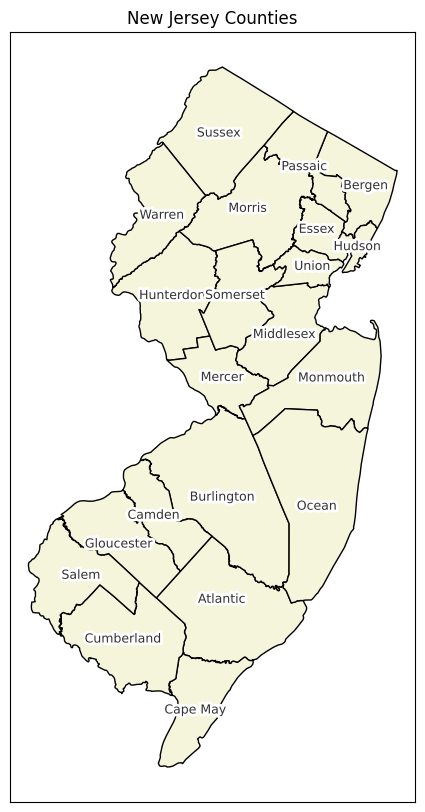

In [4]:
ax = cem.plot_map(
    gdf,
    geo_label=gdf["NAME"].apply(lambda name: name.split("County, ")[0]),
    edgecolor="black",
    color="beige",
    figsize=(8, 10),
)

_ = ax.set_title("New Jersey Counties")

## Solution 2: Provide your own key

This solution is more secure, and will not generate warnings, but it will require you
to consult with whoever set up the firewall or proxy that is causing problems for
`censusdis` in the first place.

In discussing this solution, we will assume you are familiar with how to use certificates
with the `requests` library in your Python environment. We aren't and probably can't be
since we don't work in your environment.

The sample code below does not all work in my environment, but assuming you put the appropriate
key file in the appropriate place for your environment, it should work for you.

You will need two certificates, one for https://api.census.gov so `censusdis` can get data,
and one for https://www2.census.gov so it can get maps.

In [5]:
# Adjust the paths to the two key files as appropriate. These should be the
# same files we would pass to the `cert=` argument of `requests.get` for
# each of the two sites.

# Store a key that works for https://api.census.gov in this file:
data_cert = "/path/to/certs/api-census.gov.pem"

# Store a key file that works for https://www2.census.gov in this file:
map_cert = "/path/to/certs/www-census.gov.pem"

# We will catch the exception because the paths above need to be
# chosen for your environment. They don't actually exist.

try:
    with ced.certificates.use(data_cert=data_cert, map_cert=map_cert):
        gdf = ced.download(
            dataset=ACS5,
            vintage=2022,
            download_variables=["NAME", VARIABLE_TOTAL_POPULATION],
            state=NJ,
            county="*",
            with_geometry=True,
        )
except OSError as e:
    print(e)

Could not find the TLS certificate file, invalid path: /path/to/certs/api-census.gov.pem


## Global settings

In the examples above, we always used `ced.certificates.use` as a context manager inside a `with` clause.
This is useful for constraining the effects of `ced.certificates.use` to just a few lines of code. But in
many real world non-demo cases, we just want to set it globally and forget it. Luckily, that is easy to do.
Instead of using `with`, we just call it globally. Typically, we would do this at the top of a notebook.
Here is some code that illustrates how it works with `data_verify`. If works similarly with `data_cert`, `map_verify`,
and `map_cert`.

In [6]:
print(f"Initially, ced.certificates.data_verify is {ced.certificates.data_verify}.")

# Global change.
ced.certificates.use(data_verify=False)

print(f"Now, globally, ced.certificates.data_verify is {ced.certificates.data_verify}.")

# Change it back globally.
ced.certificates.use(data_verify=True)

print(
    f"Now, globally, ced.certificates.data_verify is back to {ced.certificates.data_verify}."
)


# We can change it temporarily in a context manager.
with ced.certificates.use(data_verify=False):
    print(
        f"    Within the context, ced.certificates.data_verify is {ced.certificates.data_verify}."
    )


# And back outside the context the globally set value is back.
print(
    f"Finally, globally, ced.certificates.data_verify is {ced.certificates.data_verify}."
)

Initially, ced.certificates.data_verify is True.
Now, globally, ced.certificates.data_verify is False.
Now, globally, ced.certificates.data_verify is back to True.
    Within the context, ced.certificates.data_verify is False.
Finally, globally, ced.certificates.data_verify is True.


## Debugging with `requests.get`

If you want a simpler set of examples to debug, try the following. Whichever one you can
get to work in your environment, the corresponding solution from above should work too.

Remember, you will need to get this to work for both the data URL and the map URL.

In [7]:
import requests

# Do not ignore or replace the cert.
response = requests.get("https://api.census.gov")
response.status_code

200

In [8]:
# Skip verification
response = requests.get("https://api.census.gov", verify=False)
response.status_code

/Users/vengroff/Library/Caches/pypoetry/virtualenvs/censusdis-brFxk0td-py3.9/lib/python3.9/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.census.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/vengroff/Library/Caches/pypoetry/virtualenvs/censusdis-brFxk0td-py3.9/lib/python3.9/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.census.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/vengroff/Library/Caches/pypoetry/virtualenvs/censusdis-brFxk0td-py3.9/lib/python3.9/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.census.gov'. Adding certificate verif

200

In [9]:
# Use a certificate file
try:
    response = requests.get("https://api.census.gov", cert=data_cert)
    print(response.status_code)
except OSError as e:
    print(e)

Could not find the TLS certificate file, invalid path: /path/to/certs/api-census.gov.pem
